In [69]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random
def load(f):
    # Move up one directory when loading the data
    file_path = os.path.join('../../', f)
    return np.load(file_path)['arr_0']

# Load the data
X_train = load('kmnist-train-imgs.npz').reshape(-1, 28*28) / 255.0
x_test = load('kmnist-test-imgs.npz').reshape(-1, 28*28) / 255.0
y_train = load('kmnist-train-labels.npz')
y_test = load('kmnist-test-labels.npz')

# Reshape the data for input layer
X_train = X_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

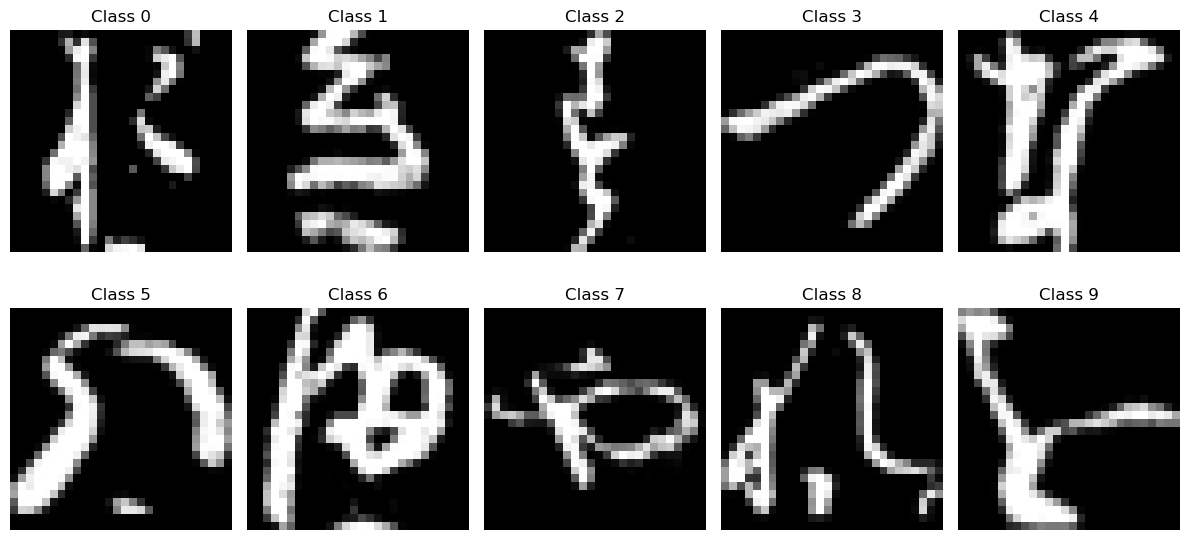

In [70]:
# Create a 2x5 grid of images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Plot a sample image for each class
for i in range(10):
    ax = axes[i // 5, i % 5]
    class_idx = random.choice(np.where(y_train == i)[0])
    ax.imshow(x_train[class_idx].reshape(28, 28), cmap='gray')
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [71]:
# Read the CSV files
accuracy_df = pd.read_csv('augmentation_accuracy.csv')
loss_df = pd.read_csv('augmentation_loss.csv')

# Accuracy vs Epoch plot
plt.figure(figsize=(10, 6))
techniques=[]
for technique in accuracy_df.columns:  # Skip the 'epoch' column
    techniques.append(technique)

# Pad the x_values to match the length of the longest technique
x_values = np.arange(len(accuracy_df))
for technique in techniques:
    plt.plot(x_values, accuracy_df[technique], label=technique)
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch for Different Augmentation Techniques')
plt.legend()
# Save the accuracy plot
plt.savefig(f'augmentation_accuracy.png')
plt.close()  # Close the current figure to start fresh for the next plot

# Loss vs Epoch plot
plt.figure(figsize=(10, 6))
for technique in loss_df.columns:  # Skip the 'epoch' column
    plt.plot(x_values, loss_df[technique], label=technique)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch for Different Augmentation Techniques')
plt.legend()
# Save the accuracy plot
plt.savefig(f'augmentation_loss.png')
plt.close()  # Close the current figure to start fresh for the next plot


In [72]:
import json

# Read the test results JSON file
with open('results.json', 'r') as f:
    results = json.load(f)

# Extract data for plotting
model_ids = [result['model_id'] for result in results]
val_accuracies = [result['val_accuracy'] for result in results]
val_losses = [result['val_loss'] for result in results]
epochs_trained = [result['epochs_trained'] for result in results]
val_learning_curves = [result['val_learning curve'][0] for result in results]
figsize=(18, 6)
# Plot Validation Accuracy vs Model ID
plt.figure(figsize=figsize)
plt.bar(model_ids, val_accuracies, color='skyblue')
plt.xlabel('Model ID')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Models')
plt.grid(True)
plt.savefig('val_accuracy_vs_model_id.png')
plt.close()

# Plot Validation Loss vs Model ID
plt.figure(figsize=figsize)
plt.bar(model_ids, val_losses, color='salmon')
plt.xlabel('Model ID')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Models')
plt.grid(True)
plt.savefig('val_loss_vs_model_id.png')
plt.close()

# Plot Validation Learning Curves
plt.figure(figsize=figsize)
for i, curve in enumerate(val_learning_curves):
    plt.plot(range(1, len(curve) + 1), curve, label=f'Model {model_ids[i]}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Learning Curves')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.savefig('val_learning_curves.png')
plt.close()


In [73]:
# print best model by validation accuracy and its hyperparameters
best_model_idx = np.argmax(val_accuracies)
best_model_id = model_ids[best_model_idx]
best_val_accuracy = val_accuracies[best_model_idx]
best_val_loss = val_losses[best_model_idx]
best_epochs_trained = epochs_trained[best_model_idx]
best_val_learning_curve = val_learning_curves[best_model_idx]

# Print entire dict for that idx
print(f'Best Model ID: {best_model_id}')
print(f'Hyperparameters: {json.dumps(results[best_model_idx], indent=2)}')


Best Model ID: 13
Hyperparameters: {
  "model_id": 13,
  "architecture": {
    "0": 1000,
    "1": 1000
  },
  "dropout_rate": 0.5,
  "optimizer": "adam",
  "learning_rate": 0.001,
  "activation": "relu",
  "val_accuracy": 0.9711666703224182,
  "val_loss": 0.10777038335800171,
  "epochs_trained": 20,
  "val_learning curve": [
    [
      0.9271666407585144,
      0.9478333592414856,
      0.9605000019073486,
      0.9593333601951599,
      0.9585000276565552,
      0.9638333320617676,
      0.9636666774749756,
      0.9643333554267883,
      0.9670000076293945,
      0.9639999866485596,
      0.968666672706604,
      0.9673333168029785,
      0.9679999947547913,
      0.9683333039283752,
      0.9693333506584167,
      0.968666672706604,
      0.9683333039283752,
      0.9678333401679993,
      0.9711666703224182,
      0.9693333506584167
    ]
  ]
}


In [74]:
# Load results.json
with open('results.json', 'r') as f:
    results = json.load(f)
# 

In [77]:
# Port json into a pandas dataframe
results_df = pd.DataFrame(results)

# Calculate average validation accuracies for each dropout rate
avg_val_accuracies = results_df.groupby('dropout_rate')['val_accuracy'].mean()

# Ensure 'architecture' column contains hashable types
results_df['architecture'] = results_df['architecture'].apply(lambda x: str(x) if isinstance(x, dict) else x)

# Calculate average validation accuracies for each architecture
avg_arch_accuracies = results_df.groupby('architecture')['val_accuracy'].mean()

# Calculate average validation accuracies for each learning rate
avg_lr_accuracies = results_df.groupby('learning_rate')['val_accuracy'].mean()

# Calculate average validation accuracies for each activation function
avg_activation_accuracies = results_df.groupby('activation')['val_accuracy'].mean()

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot histogram for dropout rates
axes[0, 0].bar(avg_val_accuracies.index, avg_val_accuracies.values, color='skyblue', edgecolor='black', width=0.1)
axes[0, 0].set_xlabel('Dropout Rate')
axes[0, 0].set_ylabel('Average Validation Accuracy')
axes[0, 0].set_title('Histogram of Average Validation Accuracies by Dropout Rate')
axes[0, 0].grid(True)

# Plot histogram for architectures
axes[0, 1].bar(avg_arch_accuracies.index, avg_arch_accuracies.values, color='lightgreen', edgecolor='black', width=0.4)
axes[0, 1].set_xlabel('Architecture')
axes[0, 1].set_ylabel('Average Validation Accuracy')
axes[0, 1].set_title('Histogram of Average Validation Accuracies by Architecture')
axes[0, 1].grid(True)

# Plot histogram for learning rates
axes[1, 0].bar(avg_lr_accuracies.index, avg_lr_accuracies.values, color='lightcoral', edgecolor='black', width=0.002)
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Average Validation Accuracy')
axes[1, 0].set_title('Histogram of Average Validation Accuracies by Learning Rate')
axes[1, 0].grid(True)

# Plot histogram for activation functions
axes[1, 1].bar(avg_activation_accuracies.index, avg_activation_accuracies.values, color='lightblue', edgecolor='black', width=0.4)
axes[1, 1].set_xlabel('Activation Function')
axes[1, 1].set_ylabel('Average Validation Accuracy')
axes[1, 1].set_title('Histogram of Average Validation Accuracies by Activation Function')
axes[1, 1].grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('histograms/combined_histograms.png')
plt.close()


In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Read the CSV files
accuracy_df = pd.read_csv('new_augmentation_accuracy.csv')
loss_df = pd.read_csv('new_augmentation_loss.csv')

# Determine the maximum length of the techniques
max_length = max(len(accuracy_df), len(loss_df))

# Pad the x_values to match the length of the longest technique
x_values = np.arange(1, max_length + 1)

# Accuracy vs Epoch plot
plt.figure(figsize=(10, 8))
for technique in accuracy_df.columns:
    padded_accuracy = np.pad(accuracy_df[technique], (0, max_length - len(accuracy_df[technique])), 'constant', constant_values=np.nan)
    plt.plot(x_values, padded_accuracy, label=technique)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch for Different Augmentation Techniques')
plt.legend()
# Save the accuracy plot
plt.savefig(f'new_augmentation_accuracy.png')
plt.close()  # Close the current figure to start fresh for the next plot

# Loss vs Epoch plot
plt.figure(figsize=(10, 6))
for technique in loss_df.columns:
    padded_loss = np.pad(loss_df[technique], (0, max_length - len(loss_df[technique])), 'constant', constant_values=np.nan)
    plt.plot(x_values, padded_loss, label=technique)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch for Different Augmentation Techniques')
plt.legend()
# Save the accuracy plot
plt.savefig(f'new_augmentation_loss.png')
plt.close()  # Close the current figure to start fresh for the next plot
